In [34]:
import torch
import torch.nn as nn
import fastai
import pandas as pd
import numpy as np
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [7]:
# defining a kernel
top_edge = torch.tensor([
    [-1, -1, 0-1],
    [0, 0, 0],
    [1, 1, 1]]).float()

In [10]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

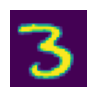

In [11]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [13]:
# convert image pixels to tensor
im3_t = tensor(im3)
# dot product of kernel over 3x3 section of img
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [14]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

So far all the pixels in the top-left corner are white so the result is not very interesting. Let's pic a couple more spots:

In [16]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [17]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [18]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [19]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

In [21]:
apply_kernel(5, 7, top_edge)

tensor(762.)

In [22]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<Axes: >

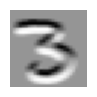

In [25]:
rng = range(1, 27)
top_edge3 = torch.tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3)

Top edges are black and bottom edges are white since they are the opposite of top edges.

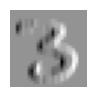

In [26]:
# try the same thing for left edges
left_edge = torch.tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = torch.tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

In [27]:
# diagonal edge kernels

diag1_edge = torch.tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = torch.tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [28]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [29]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [30]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [31]:
edge_kernels = edge_kernels.unsqueeze(1)

In [32]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

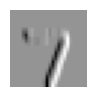

In [33]:
show_image(batch_features[0,0]);

## Convolutional Neural Net

Instead of manually setting the values of the different kernels like we did above, we can simply "learn" these values! We already know how to do this with SGD. In effect, the model will learn the features that are useful for classification.

When we use convolutions instead of (or in addition to) regular linear layers we create a convolutional neural net (CNN).

In [35]:
# basic neural net we defined in mnist chapter
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [36]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

We now want to create a similar architecture to this linear model, but using convolutional layers instead of linear. nn.Conv2d is the module equivalent of F.conv2d. It's more convenient than F.conv2d when creating an architecture, because it creates the weight matrix for us automatically when we instantiate it.

In [37]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

We did not need to specify the input size as 28x28. A linear layer needs a weight for every pixel (hence 28x28 or 784 weights). But a convolution is applied over each pixel automatically. Weights only depend on the number of input  and output channels and the kernel size. Because the weights in a conv layer are the kernel values themselves!

In [38]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [39]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [41]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    nn.Flatten(),
)

In [42]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [43]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [44]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [45]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.064603,0.039215,0.986261,00:08
1,0.017486,0.017230,0.993131,00:04


### Understanding Convolution Arithmetic

Looking at the summary, we can see the input is of size `[64x1x28x28]`. This is batch_size, channle, height, width.

In [47]:
# first layer
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [48]:
# weights from first convolution
m[0].weight.shape

torch.Size([4, 1, 3, 3])

This tells us the first layer has 4 different 3x3 kernels. These are the weights. This is 40 parameters in this layer:
--> 4*1*3*3 = 36 + 4 = 40

Add 4 for the biases, one for each kernel/weight matrix.

In [49]:
m[0].bias.shape

torch.Size([4])

In [50]:
# moving on to full mnist dataset
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [51]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

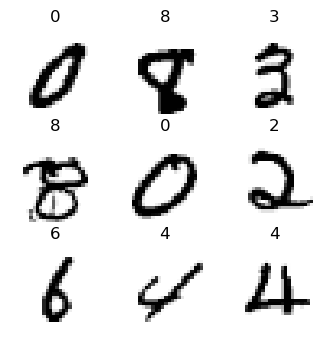

In [52]:
# take a look at the data first
dls.show_batch(max_n=9, figsize=(4,4))

In [54]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [55]:
from fastai.callback.hook import *


def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [56]:
learn = fit()

/opt/anaconda3/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.469742,0.332056,0.895800,00:28


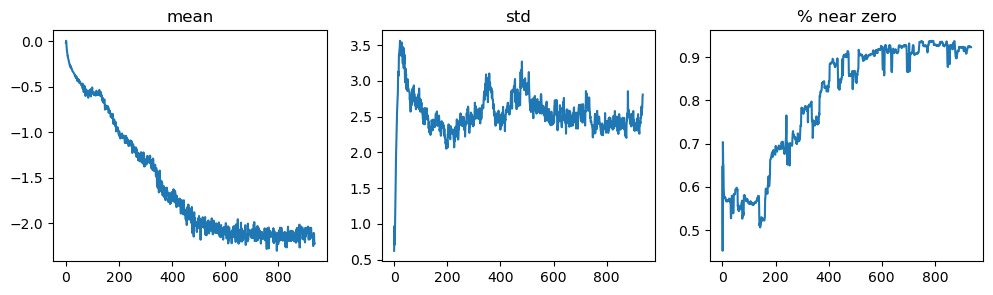

In [57]:
learn.activation_stats.plot_layer_stats(0)

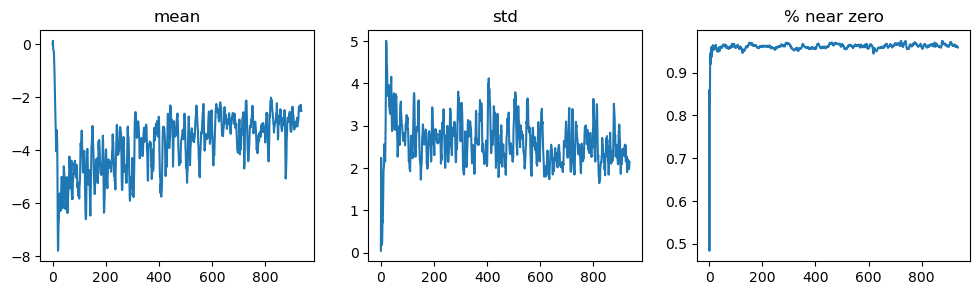

In [58]:
learn.activation_stats.plot_layer_stats(-2)

In [59]:
# increase batch_size
dls = get_dls(512)

In [60]:
learn = fit()

/opt/anaconda3/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.308737,2.302797,0.113500,00:23


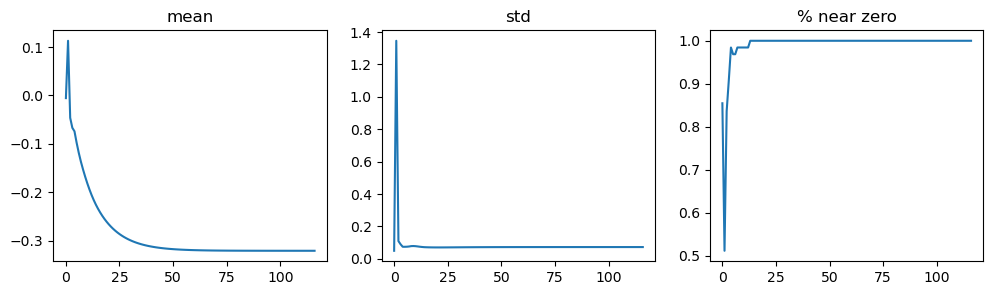

In [61]:
learn.activation_stats.plot_layer_stats(-2)

In [62]:
# use 1cycle training in fastai with fit_one_cycle
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [63]:
learn = fit()

/opt/anaconda3/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.202164,0.075857,0.975100,00:23


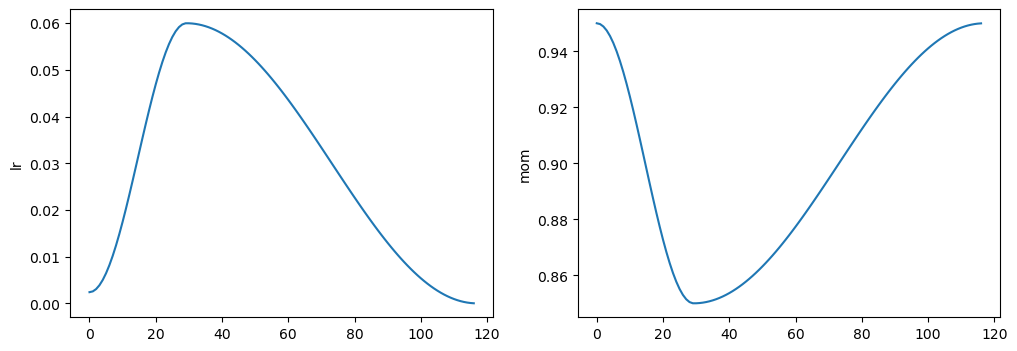

In [64]:
# plot learning rate and momentum schedule of training run
learn.recorder.plot_sched()

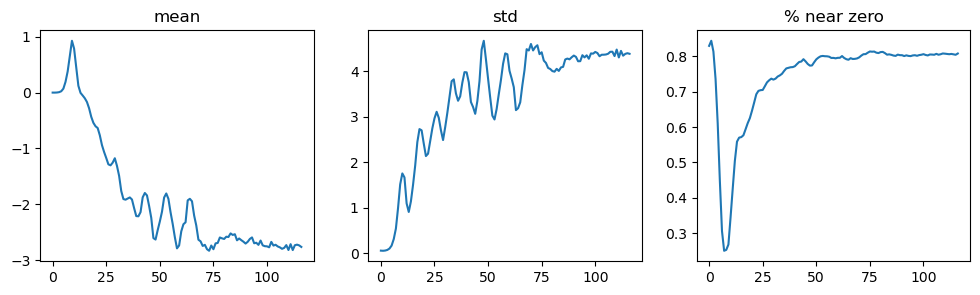

In [65]:
learn.activation_stats.plot_layer_stats(-2)

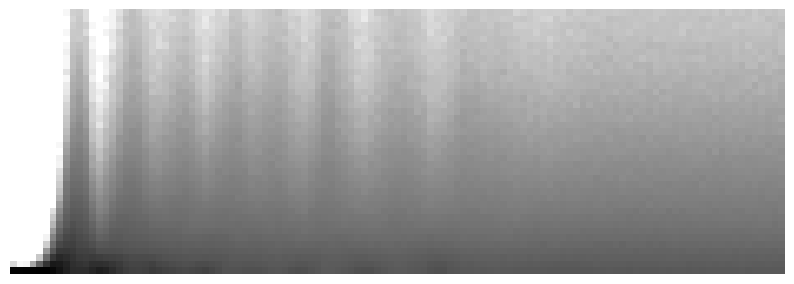

In [66]:
learn.activation_stats.color_dim(-2)

In [67]:
# add a batchnorm layer to conv
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [69]:
learn = fit()

/opt/anaconda3/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.129164,0.055686,0.985400,00:26


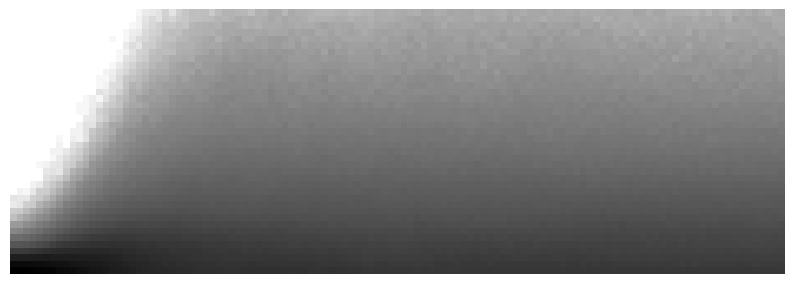

In [70]:
learn.activation_stats.color_dim(-4)

In [71]:
# increase epochs and learning rate
learn = fit(5, lr=0.1)

/opt/anaconda3/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.185249,0.116667,0.964900,00:25
1,0.081143,0.046635,0.984600,00:24
2,0.051816,0.061309,0.980200,00:24
3,0.031502,0.027217,0.991300,00:24
4,0.015455,0.022638,0.992500,00:24
